# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a GRU unit.
Gated Recurrent Units are one kind of RNNs. 

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [12]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

nb, if you are running locally you can skip the step below and change the paths later to point to the folder with your previous download of the datasets.

In [4]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  14.8M      0 --:--:--  0:00:22 --:--:-- 17.8M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


In [13]:
# task: normalizzo le features 

#faccio il reshape per passare da un dataset di size (nj,np,nf)->(nj*np,nf)

#train
nj=X_train.shape[0]
n_p=X_train.shape[1]
nf=X_train.shape[2]
n_new=nj*n_p
#print(type(X_train))
#print(type(n_new), type(nf))
new_train=np.reshape(X_train,(n_new,nf))
print(new_train.shape, n_new)

#da fare anche per X_val!

(3350000, 16) 3350000


In [15]:
import pandas as pd

print(pd.DataFrame(new_train[:5,:]))

           0           1           2           3         4           5   \
0 -174.065872  191.449799 -242.940063  354.925110  0.198780  258.750763   
1  -96.874695  106.657539 -134.528931  197.125824  0.110403  144.085175   
2  -69.979179   77.745834  -98.210052  143.480713  0.080358  104.601624   
3  -57.844669   80.805115  -84.903137  130.705902  0.073204   99.375412   
4  -61.115868   67.329201  -85.046448  124.504166  0.069730   90.930580   

         6         7         8             9         10        11        12  \
0  0.197174 -0.837500 -0.013387  0.000000e+00  2.308670  0.030141  0.000000   
1  0.109796 -0.833690 -0.009577  3.110584e-03  2.308166  0.029637 -0.002257   
2  0.079709 -0.837500 -0.013387 -2.381772e-03  2.303668  0.025138 -0.004399   
3  0.075726 -0.774562  0.049551  1.657324e-14  2.192084 -0.086446 -0.132403   
4  0.069291 -0.834869 -0.010755  1.927597e-03  2.307859  0.029329 -0.001967   

         13        14            15  
0  0.032980 -0.684483  6.123234e-17 

In [16]:
#normalizziamoooooo

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_train=scaler.fit_transform(new_train)

print(pd.DataFrame(new_train[:5,:]))


         0         1         2         3         4         5         6   \
0 -6.883170  7.601083 -6.769922  7.009325  5.828180  7.276984  5.764971   
1 -3.831590  4.233427 -3.747967  3.765627  3.099788  3.916055  3.073457   
2 -2.768336  3.085154 -2.735580  2.662906  2.172250  2.758764  2.146670   
3 -2.288626  3.206658 -2.364651  2.400309  1.951370  2.605580  2.023997   
4 -2.417945  2.671441 -2.368645  2.272827  1.844140  2.358056  1.825773   

         7         8         9         10        11        12        13  \
0 -1.575534 -0.167330  0.000234  1.816271  0.379917  0.363434 -0.310036   
1 -1.568347 -0.120131  0.043292  1.815873  0.373555  0.341383 -0.329458   
2 -1.575534 -0.167330 -0.032736  1.812321  0.316792  0.320464 -0.357675   
3 -1.456829  0.612327  0.000234  1.724213 -1.091260 -0.929847  0.395762   
4 -1.570571 -0.134733  0.026917  1.815630  0.369676  0.344225 -0.328467   

         14        15  
0 -1.757688  0.000210  
1 -1.752462  0.044307  
2 -1.757688 -0.033555  
3 

In [17]:
X_train_2=np.reshape(new_train,(nj,n_p,nf))
print(X_train_2.shape)

(33500, 100, 16)


In [18]:
X_train=X_train_2

# Building the RNN model

A recurrent neural network (RNN) is a type of NN which processes sequential data or time series data. They are commonly used for ordinal or temporal problems, such as natural language processing (NLP). They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output.

<img src="https://github.com/NoemiTagliavacche/ML_course_Pavia_23/blob/main/neural-networks/figures/rnn1.png?raw=1" alt="Drawing" style="width: 600px;"/>

In this notebook we treat the particles clustered by the jet algorithm as an ordered sequence processed through a type of RNN called [Gated Recurrent Units](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be). GRUs are improved version of standard RNN that solves the solves the vanishing gradient problem. The update and reset gates decide what information should be passed to the output making the model able to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction. The main ingredients are:

- number of hidden units: the size of the hidden state *ht*
- gates activation function (typically a sigmoid between 0 and 1 to either let no flow or complete flow of information throughout the gates)
- current state activation function (typically a tanh between -1 and 1 to allow for increases and decreases in the state)

In [22]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Dropout,Masking
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [20]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [23]:
####
inputList = Input(shape=(featureArrayLength))
x= Masking(mask_value=0.0)(inputList) # aggiungo la maschera perchè il mio dataset originare è fatto da 100 particelle fisse mentre GRU
# vuole in ingresso data with variable lenghts e questo fa si che io abbia variable dataset
x = GRU(units=40, activation="tanh", recurrent_activation='sigmoid')(inputList)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 gru (GRU)                   (None, 40)                6960      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0     

We now train the model

In [25]:
batch_size = 128
n_epochs = 200

In [26]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 29s - loss: 1.6088 - val_loss: 1.6087 - lr: 0.0010 - 29s/epoch - 109ms/step
Epoch 2/200
262/262 - 18s - loss: 1.5752 - val_loss: 1.6057 - lr: 0.0010 - 18s/epoch - 70ms/step
Epoch 3/200
262/262 - 20s - loss: 1.3912 - val_loss: 1.6599 - lr: 0.0010 - 20s/epoch - 75ms/step
Epoch 4/200

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
262/262 - 18s - loss: 1.3332 - val_loss: 1.6836 - lr: 0.0010 - 18s/epoch - 69ms/step
Epoch 5/200
262/262 - 19s - loss: 1.3079 - val_loss: 1.6927 - lr: 1.0000e-04 - 19s/epoch - 74ms/step
Epoch 6/200

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
262/262 - 23s - loss: 1.3036 - val_loss: 1.7170 - lr: 1.0000e-04 - 23s/epoch - 89ms/step
Epoch 7/200
262/262 - 18s - loss: 1.3019 - val_loss: 1.7096 - lr: 1.0000e-05 - 18s/epoch - 70ms/step
Epoch 8/200

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
262/262 - 22s - loss: 1.3022 - val_loss: 1.7059 - lr: 1.0000e-

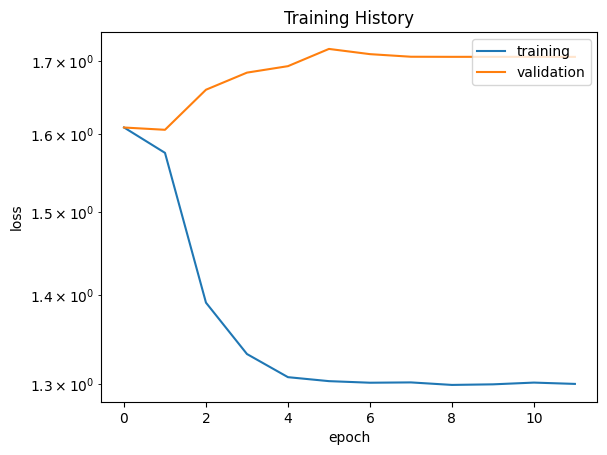

In [27]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [29]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 6s 12ms/step


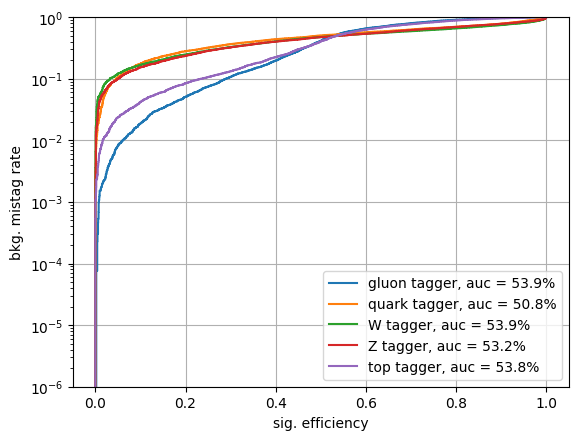

In [30]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()